# Signal Induced Noise Analysis

### Introduction
<p style='text-align: justify'>
The Signal Induced Noise (SIN) measurement is used to quantify the constitution of after-pulses with respect to a true signal. After calculating the integrated signal and the integrated SIN, the SIN Fraction can be calculated using the following formula:
$$SIN_{fraction}=\frac{noise}{signal+noise}$$
together with the Signal to Noise (S/N) ratio:
$$SN_{ratio} =\frac{signal}{noise}$$
The purpose of this analysis is to calculate both parameters to get an information about the intensity of the SIN to the signal for each pixel of Multi-Anode Photomultiplier Tubes (MaPMTs).

The following notebook analyses the Elementary Cell of R-type and H-type in terms of SIN. It saves all the generated plots in the \output file. As there are a lot of plots, only the first plot is shown in the following notebook.
</p>

### Procedure
1. Extract the mapping data.
2. Extract the measurement data.
3. Calculate $SIN_{fraction}$ and $SIN_{ratio}$ for each channel.
4. Exclude disabled channels.
5. Produce 2D histograms of a scheme of anodes, $SIN_{fraction}$ and $SIN_{ratio}$ as a representation of an Elementary Cell.
6. Produce 1D histograms of $SIN_{fraction}$ and $SIN_{ratio}$ for all the channels.
7. Produce SIN spectrum for each of the channels.
8. Determine min, max and mean values of $SIN_{fraction}$ and $SIN_{ratio}$ for a selected EC based on three distinctive SIN influenced regions.

### Libraries
Importing essential libraries: numpy, pandas, matplotlib and seaborn.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

### Load selection
Load refers to a complete measurement of 4 Elementary Cells. The data has been uploaded for 10 loads from two stations.  
- To select a station, provide "S1" or "S2".
- To select a load, provide a number from "0001" up to "00005".
- To select the type of an Elementary Cell, provide either "R" (for loads "0001", "0002" and "0003") or "H" for (loads "0004" and "0005").

In [4]:
station = "S1"
load = "0001"
ectype = "R"

### Mapping data
Extraction of the mapping data for an Elementary Cell of R-Type and H-Type. Identification is required to be included in the graphs as there are 1024 channels for R-type and 256 channels for H-type.

In [5]:
ECs_df = pd.DataFrame()

In [6]:
def Mapping(ectype):
    
    map_IDs = []
    map_ECs = []
    map_PMTs = []
    map_anodes = []
    
    if ectype == 'R':
        with open('mapping/R_Map.txt') as file:
            map_data = file.readlines()[1:]
    elif ectype == "H":
        with open('mapping/H_Map.txt') as file:
            map_data = file.readlines()[1:]
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

    for i in range(0, len(map_data)):
        map_channel = map_data[i].split(' ')

        map_ID = ' '.join(map_channel[0:4])
        map_IDs.append(map_ID)

        map_EC = int(map_channel[4])
        map_ECs.append(map_EC)

        if ectype == 'R':
            map_PMT = map_channel[5]
            map_PMTs.append(map_PMT)
            
            map_anode = int(map_channel[6])
            map_anodes.append(map_anode)
        elif ectype == 'H':
            map_anode = int(map_channel[5])
            map_anodes.append(map_anode)

    map_IDs = np.array(map_IDs)
    map_ECs = np.array(map_ECs)
    if ectype == 'R':
        map_PMTs = np.array(map_PMTs)
    map_anodes = np.array(map_anodes)

    ECs_df['ID'] = map_IDs
    ECs_df['EC'] = map_ECs
    if ectype == 'R':
        ECs_df['PMT'] = map_PMTs
    ECs_df['Anode'] = map_anodes

In [7]:
Mapping(ectype)

In [8]:
ECs_df

,ID,EC,PMT,Anode
0,0 0 0 0,3,D,37
1,0 0 0 1,3,D,45
2,0 0 0 2,3,D,38
3,0 0 0 3,3,D,46
4,0 0 0 4,3,D,39
...,...,...,...,...
1019,7 1 7 3,2,B,6
1020,7 1 7 4,2,B,15
1021,7 1 7 5,2,B,7
1022,7 1 7 6,2,B,16


### Measurement data
Extraction of the measurement data for the specified load. $SIN_{fraction}$ and $SIN_{ratio}$ are calculated immediately. Fortunately, the order of the measurement data matches the mapping data hence no additional action is required.

In [9]:
def Data(station, load, ectype):
    
    with open(f'data/station-{station[1]}/Load_{load}_{ectype}_{station}/SIN_1000V_cfgOptThr.txt') as file:
        data = file.readlines()[12:]
        
    IDs = []
    spectrums = []
    signal_indexes = []
    signals = []
    noises = []
    SIN_Fractions = []
    Signals_to_Noises = []
    
    for i in range(0,len(data)):
        data_channel = data[i]

        ID = data_channel.split("\t")[0:4]
        IDs.append(ID)  

        spectrum = [int(x) for x in data_channel.split("\t")[4:]]
        spectrums.append(spectrum)

        signal_index = np.argmax(spectrum)
        signal_indexes.append(signal_index)

        signal = spectrum[signal_index] + spectrum[signal_index+1]
        signals.append(signal)

        noise = np.sum(spectrum[signal_index+2:])
        noises.append(noise)

        SIN_Fraction = np.around(noise/(noise + signal)*100, 2)
        Signal_to_Noise = np.around(signal/noise, 2)

        SIN_Fractions.append(SIN_Fraction)
        Signals_to_Noises.append(Signal_to_Noise)

    IDs = np.array(IDs)
    spectrums = np.array(spectrums)
    signal_indexes = np.array(signal_indexes)
    signals = np.array(signals)
    noises = np.array(noises)

    SIN_Fractions = np.array(SIN_Fractions)
    Signals_to_Noises = np.array(Signals_to_Noises)
    
    IDs_list = IDs.tolist()
    spectrums_list = spectrums.tolist()
    
    ECs_df['Channel_ID'] = IDs_list
    ECs_df['SIN_Spectrum'] = spectrums_list
    ECs_df['SIN_Signal'] = signals
    ECs_df['SIN_Noise'] = noises
    ECs_df['SIN_Fraction'] = SIN_Fractions
    ECs_df['SN_Ratio'] = Signals_to_Noises  

In [10]:
Data(station, load, ectype)

In [11]:
ECs_df

,ID,EC,PMT,Anode,Channel_ID,SIN_Spectrum,SIN_Signal,SIN_Noise,SIN_Fraction,SN_Ratio
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221...",25885,263,1.01,98.42
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 242...",31150,588,1.85,52.98
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300...",32457,291,0.89,111.54
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 299...",34215,689,1.97,49.66
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 261...",28121,310,1.09,90.71
...,...,...,...,...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]","[1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 363...",37722,46133,55.02,0.82
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 475...",48628,10084,17.18,4.82
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 385...",39565,28527,41.89,1.39
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 391...",39816,5362,11.87,7.43


### Exclusion of disabled channels
For the ECs of H-type, half of the rows are empty as the channels are turned off. Empty rows are indicated by anodes equal to 0. For the ECs of R-type, no cleaning is required as all the channels are active (but the function can be run anyway).

In [12]:
def Empty_Anodes_Delete():
    ECs_df.drop(ECs_df[ECs_df['Anode']==0].index, inplace=True)
    ECs_df.reset_index(drop=True, inplace=True)

In [13]:
Empty_Anodes_Delete()

In [14]:
ECs_df

,ID,EC,PMT,Anode,Channel_ID,SIN_Spectrum,SIN_Signal,SIN_Noise,SIN_Fraction,SN_Ratio
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 221...",25885,263,1.01,98.42
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 242...",31150,588,1.85,52.98
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300...",32457,291,0.89,111.54
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 299...",34215,689,1.97,49.66
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 261...",28121,310,1.09,90.71
...,...,...,...,...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]","[1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 363...",37722,46133,55.02,0.82
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 475...",48628,10084,17.18,4.82
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 385...",39565,28527,41.89,1.39
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 391...",39816,5362,11.87,7.43


### 2D Histograms (Heatmaps)
The 2D histograms are arranged in 8x8 matrix. For the R-type, there are four 8x8 matrices where each of them is rotated by 90$^{\circ}$ to the preceeding one. For the H-type, there is only one 8x8 matrix. As there are multiple plots to be generated, only the first plot is presented in the notebook, the rest can be seen in .pdf files in the \output folder. Three kinds of histograms can be produced:
- scheme of anodes $\;\;\;$ (analysis = 'Anode'),
- $SIN_{fraction}$ $\;\;\;\;\;\;\;\;\;\;$ (analysis = 'SIN_Fraction'),
- $SIN_{ratio}$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ (anaysis = 'SN_Ratio').

Below, a figure presenting a scheme of one load of R-type (left) and H-type (right).

<img src="materials\EC_Scheme.png" alt="Drawing" style="width: 100%;"/>

In [15]:
def Histograms_2D(station, load, ectype, analysis):
    
    if analysis == 'Anode':
        to_title = 'Numbering of Anodes'
        to_map = ListedColormap(['white'])
        to_format = None
        to_fmt = 'g'
        to_cbar = False
    elif analysis == 'SIN_Fraction':
        to_title = 'SIN Fraction [%]'
        to_map = 'coolwarm'
        to_format = '%.0f%%'
        to_fmt = '.2f'
        to_cbar = True
    elif analysis == 'SN_Ratio':
        to_title = 'S/N Ratio'
        to_map = 'coolwarm'
        to_format = None
        to_fmt = '.2f'
        to_cbar = True
    else:
        pass
        
    if ectype=='R':
        EC_0_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_A = ECs_df[(ECs_df['PMT']=='A') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_B = ECs_df[(ECs_df['PMT']=='B') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_C = ECs_df[(ECs_df['PMT']=='C') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==0)].sort_values(by='Anode')
        EC_1_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==1)].sort_values(by='Anode')
        EC_2_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==2)].sort_values(by='Anode')
        EC_3_PMT_D = ECs_df[(ECs_df['PMT']=='D') & (ECs_df['EC']==3)].sort_values(by='Anode')

        EC_0_PMT_C_matrix = np.array(np.array_split(EC_0_PMT_C[f'{analysis}'].values, 8))
        EC_1_PMT_C_matrix = np.array(np.array_split(EC_1_PMT_C[f'{analysis}'].values, 8))
        EC_2_PMT_C_matrix = np.array(np.array_split(EC_2_PMT_C[f'{analysis}'].values, 8))
        EC_3_PMT_C_matrix = np.array(np.array_split(EC_3_PMT_C[f'{analysis}'].values, 8))

        EC_0_PMT_D_matrix = np.rot90(np.array_split(EC_0_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_1_PMT_D_matrix = np.rot90(np.array_split(EC_1_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_2_PMT_D_matrix = np.rot90(np.array_split(EC_2_PMT_D[f'{analysis}'].values, 8), k = 3)
        EC_3_PMT_D_matrix = np.rot90(np.array_split(EC_3_PMT_D[f'{analysis}'].values, 8), k = 3)

        EC_0_PMT_A_matrix = np.rot90(np.array_split(EC_0_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_1_PMT_A_matrix = np.rot90(np.array_split(EC_1_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_2_PMT_A_matrix = np.rot90(np.array_split(EC_2_PMT_A[f'{analysis}'].values, 8), k = 2)
        EC_3_PMT_A_matrix = np.rot90(np.array_split(EC_3_PMT_A[f'{analysis}'].values, 8), k = 2)

        EC_0_PMT_B_matrix = np.rot90(np.array_split(EC_0_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_1_PMT_B_matrix = np.rot90(np.array_split(EC_1_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_2_PMT_B_matrix = np.rot90(np.array_split(EC_2_PMT_B[f'{analysis}'].values, 8), k = 1)
        EC_3_PMT_B_matrix = np.rot90(np.array_split(EC_3_PMT_B[f'{analysis}'].values, 8), k = 1)

        PMTs_A = [EC_0_PMT_A_matrix, EC_1_PMT_A_matrix, EC_2_PMT_A_matrix, EC_3_PMT_A_matrix]
        PMTs_B = [EC_0_PMT_B_matrix, EC_1_PMT_B_matrix, EC_2_PMT_B_matrix, EC_3_PMT_B_matrix]
        PMTs_C = [EC_0_PMT_C_matrix, EC_1_PMT_C_matrix, EC_2_PMT_C_matrix, EC_3_PMT_C_matrix]
        PMTs_D = [EC_0_PMT_D_matrix, EC_1_PMT_D_matrix, EC_2_PMT_D_matrix, EC_3_PMT_D_matrix]

        for EC in range(0,4):        

            fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 9))

            sns.heatmap(PMTs_A[EC], ax = ax[0,0], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[0,0].get_ylim()
            ax[0,0].set_ylim(bottom + 0.5, top - 0.5)
            ax[0,0].set_title(f'PMT A - {to_title}')

            sns.heatmap(PMTs_B[EC], ax = ax[0,1], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[0,1].get_ylim()
            ax[0,1].set_ylim(bottom + 0.5, top - 0.5)
            ax[0,1].set_title(f'PMT B - {to_title}')

            sns.heatmap(PMTs_D[EC], ax = ax[1,0], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8,}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[1,0].get_ylim()
            ax[1,0].set_ylim(bottom + 0.5, top - 0.5)
            ax[1,0].set_title(f'PMT D - {to_title}')

            sns.heatmap(PMTs_C[EC], ax = ax[1,1], cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax[1,1].get_ylim()
            ax[1,1].set_ylim(bottom + 0.5, top - 0.5)
            ax[1,1].set_title(f'PMT C - {to_title}')

            fig.tight_layout()

            plt.savefig(f"output/{station}_{ectype}_{load}_SIN_Histogram2D_{analysis}_EC_{EC}.pdf")
            
            if EC==0:
                plt.show()
            else:
                plt.close()
            
    elif ectype=='H':
        EC_0 = ECs_df[ECs_df['EC']==0].sort_values(by='Anode')
        EC_1 = ECs_df[ECs_df['EC']==1].sort_values(by='Anode')
        EC_2 = ECs_df[ECs_df['EC']==2].sort_values(by='Anode')
        EC_3 = ECs_df[ECs_df['EC']==3].sort_values(by='Anode')
        
        EC_0_matrix = np.rot90(np.array_split(EC_0[f'{analysis}'].values, 8), k = 2)
        EC_1_matrix = np.rot90(np.array_split(EC_1[f'{analysis}'].values, 8), k = 2)
        EC_2_matrix = np.rot90(np.array_split(EC_2[f'{analysis}'].values, 8), k = 2)
        EC_3_matrix = np.rot90(np.array_split(EC_3[f'{analysis}'].values, 8), k = 2)
        
        ECs = [EC_0_matrix, EC_1_matrix, EC_2_matrix, EC_3_matrix]
        
        for EC in range(0,4):        

            fig = plt.figure(figsize=(12,9))
            ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

            sns.heatmap(ECs[EC], ax = ax, cmap = to_map, linewidths=0.5, linecolor='black', square = True, annot = True, annot_kws={"size": 8}, fmt=to_fmt, cbar = to_cbar, cbar_kws={'format': to_format}, xticklabels = False, yticklabels = False)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom + 0.5, top - 0.5)
            ax.set_title(f'PMT - {to_title}')

            plt.savefig(f"output/{station}_{ectype}_{load}_SIN_Histogram2D_{analysis}_EC_{EC}.pdf")
            
            if EC==0:
                plt.show()
            else:
                plt.close()
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

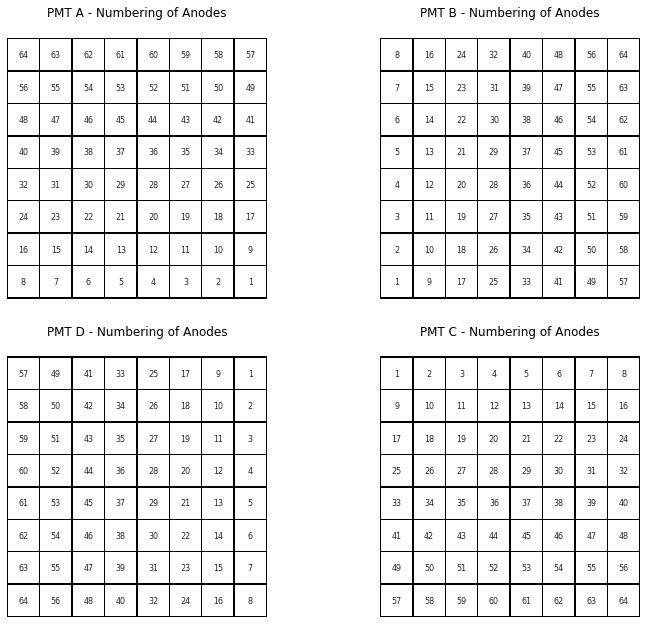

KeyboardInterrupt: 

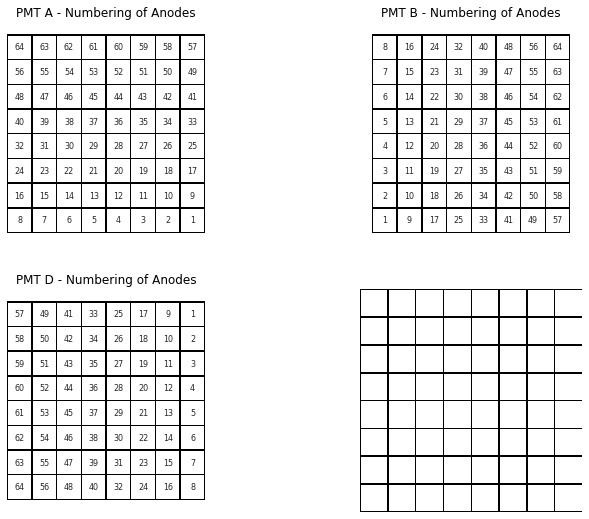

In [16]:
Histograms_2D(station, load, ectype, "Anode")

In [ ]:
Histograms_2D(station, load, ectype, "SIN_Fraction")

In [ ]:
Histograms_2D(station, load, ectype, "SN_Ratio")

### 1D Histograms
The 1D histograms give an insight of the intensity of the SIN for the whole load (4 ECs). Two kinds of histograms can be produced:
- $SIN_{fraction}$ $\;\;\;\;\;\;\;\;\;\;$ (analysis = 'SIN_Fraction'),
- $SIN_{ratio}$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ (anaysis = 'SN_Ratio').

In [ ]:
def Histograms_1D(station, load, ectype, analysis):
    
    if analysis == 'SIN_Fraction':
        to_title = 'SIN Fraction'
        x_label = 'SIN Fraction [%]'
        my_bins = 100
        limits = [0, 100]
    elif analysis == 'SN_Ratio':
        to_title = 'S/N Ratio'
        x_label = 'S/N Ratio'
        my_bins = 100
        limits = [0, 1000]
    else:
        pass
        
    for EC in range(0, 4):
        if ectype=='R':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'PMT', 'Anode']).reset_index(drop=True)
        elif ectype=='H':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'Anode']).reset_index(drop=True)
        else:
            raise ValueError('Wrong type of an Elementary Cell.')
            
        fig = plt.figure(figsize=(12,9))
        ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
        ax.set_title(f'{to_title}')
        ax.set_xlabel(f'{x_label}')
        ax.set_ylabel('#')
        
        a = sns.histplot(EC_df[analysis], kde=False, bins=20, line_kws={'linewidth': '1', 'edgecolor': 'black'})
        a.set(xlim=limits)

        plt.savefig(f"output/{station}_{ectype}_{load}_SIN_Histogram1D_{analysis}_EC_{EC}.pdf")      
        
        if EC==0:
            plt.show()
        else:
            plt.close()

In [ ]:
Histograms_1D(station, load, ectype, "SIN_Fraction")

In [ ]:
Histograms_1D(station, load, ectype, "SN_Ratio")

### Spectra
The spectra present the distribution of the SIN for each of the channel. Each channel has its own spectrum as registered counts to the SIN step. The range of the SIN step goes from 0 to 255 where each step equals to 25ns. The number of 1024 and 256 spectra are produced for R-type and H-type, respectively. In the notebook the spectrum for the first channel is presented, the rest can be found in the \output folder.

In [ ]:
def Spectra(station, load, ectype, analysis):
    
    steps = range(0,256)
    
    for EC in range(0, 4):
        if ectype=='R':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'PMT', 'Anode']).reset_index(drop=True)
        elif ectype=='H':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'Anode']).reset_index(drop=True)
        else:
            raise ValueError('Wrong type of an Elementary Cell.')
            
        with PdfPages(f"output/{station}_{ectype}_{load}_SIN_Spectrum_{analysis}_EC_{EC}.pdf") as pdf:
            for i in range(0, len(EC_df)):
                fig = plt.figure(figsize=(12,9))
                ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

                if ectype=='R':
                    ax.set_title(f'SIN Spectrum of PMT: {EC_df.loc[i, "PMT"]} Anode: {EC_df.loc[i, "Anode"]} (UART: {EC_df.loc[i, "ID"][0]} FEB: {EC_df.loc[i, "ID"][2]} CHIP: {EC_df.loc[i, "ID"][4]} CHANNEL: {EC_df.loc[i, "ID"][6]})')
                elif ectype=='H':
                    ax.set_title(f'SIN Spectrum of Anode: {EC_df.loc[i, "Anode"]} (UART: {EC_df.loc[i, "ID"][0]} FEB: {EC_df.loc[i, "ID"][2]} CHIP: {EC_df.loc[i, "ID"][4]} CHANNEL: {EC_df.loc[i, "ID"][6]})')        
                                 
                ax.set_xlabel('Steps (0-255)')
                ax.set_ylabel('Counts')

                ax.set_yscale('log')

                ax.plot(steps, EC_df.loc[i, analysis], drawstyle='steps-mid', linewidth = 0.5)

                pdf.savefig()
                plt.rcParams.update({'figure.max_open_warning': 0})
                
                if (EC==0) & (i==0):
                    plt.show()
                else:
                    plt.close()

In [ ]:
Spectra(station, load, ectype, 'SIN_Spectrum')

### Regions
During the analysis, it was found that the SIN intensity depends on the region of an EC. Thre distincive regions can be found as presented in the figure below. The following function provides the min, max and mean values for selected EC of a specific load for these regions. The function works only for the R-type EC as they were the subject of the analysis due to the fact that they are placed in the regions of highest occupancy.

<img src="materials\Regions.png" alt="Drawing" style="width: 50%;"/>

In [ ]:
def Regions(station, load, ectype, EC_number):

    if ectype=='H':
        print('The region function is not used for the H-type EC. Please switch to the R-type')
    elif ectype=='R':
        anodes_all = ECs_df[ECs_df['EC']==EC_number]
        anodes_red = ECs_df[(ECs_df['EC']==EC_number) & (ECs_df['Anode'].isin([1,2,3,4,5,6,7,8,57,58,59,60,61,62,63,64]))]
        anodes_blue = ECs_df[(ECs_df['EC']==EC_number) & 
                  ((((ECs_df['PMT']=='A') | (ECs_df['PMT']=='C')) & (ECs_df['Anode'].isin([9,10,11,12,13,14,15,16,49,50,51,52,53,54,55,56,17,24,25,32,33,40,41,48]))) | 
                  (((ECs_df['PMT']=='B') | (ECs_df['PMT']=='D')) & (ECs_df['Anode'].isin([10,11,12,13,14,15,50,51,52,53,54,55,9,16,17,24,25,32,33,40,41,48,49,56]))))
                 ]
        anodes_green = ECs_df[(ECs_df['EC']==EC_number) & (ECs_df['Anode'].isin([18,19,20,21,22,23,26,27,28,29,30,31,34,35,36,37,38,39,42,43,44,45,46,47]))]


        print(f"""EC: {EC_number} (station: {station}, load: {load}, ectype: {ectype})
        ---
        Anodes hardly affected by SIN (green zone):
        SIN Fraction:
        - min: {np.around(anodes_green['SIN_Fraction'].min(), 2)} 
        - max: {np.around(anodes_green['SIN_Fraction'].max(), 2)}
        - mean: {np.around(anodes_green['SIN_Fraction'].mean(), 2)}  
        S/N Ratio:
        - min: {np.around(anodes_green['SN_Ratio'].min(), 2)}
        - max: {np.around(anodes_green['SN_Ratio'].max(), 2)}
        - mean: {np.around(anodes_green['SN_Ratio'].mean(), 2)}   
        ---
        Anodes somewhat affected by SIN (blue zone):
        SIN Fraction:
        - min: {np.around(anodes_blue['SIN_Fraction'].min(), 2)} 
        - max: {np.around(anodes_blue['SIN_Fraction'].max(), 2)}
        - mean: {np.around(anodes_blue['SIN_Fraction'].mean(), 2)}  
        S/N Ratio:
        - min: {np.around(anodes_blue['SN_Ratio'].min(), 2)}
        - max: {np.around(anodes_blue['SN_Ratio'].max(), 2)}
        - mean: {np.around(anodes_blue['SN_Ratio'].mean(), 2)}        
        ---
        Anodes greatly affected by SIN (red zone):
        SIN Fraction:
        - min: {np.around(anodes_red['SIN_Fraction'].min(), 2)} 
        - max: {np.around(anodes_red['SIN_Fraction'].max(), 2)}
        - mean: {np.around(anodes_red['SIN_Fraction'].mean(), 2)}  
        S/N Ratio:
        - min: {np.around(anodes_red['SN_Ratio'].min(), 2)}
        - max: {np.around(anodes_red['SN_Ratio'].max(), 2)}
        - mean: {np.around(anodes_red['SN_Ratio'].mean(), 2)}   
        ---
        All anodes affected by SIN:
        SIN Fraction:
        - min: {np.around(anodes_all['SIN_Fraction'].min(), 2)} 
        - max: {np.around(anodes_all['SIN_Fraction'].max(), 2)}
        - mean: {np.around(anodes_all['SIN_Fraction'].mean(), 2)}  
        S/N Ratio:
        - min: {np.around(anodes_all['SN_Ratio'].min(), 2)}
        - max: {np.around(anodes_all['SN_Ratio'].max(), 2)}
        - mean: {np.around(anodes_all['SN_Ratio'].mean(), 2)}       
          """)
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

In [ ]:
ecnumber = 0
Regions(station, load, ectype, ecnumber)